# Predicting the Source of Wildfires
Luke Waninger  
DATA 512 Final Project  
University of Washington, Fall 2018  
__[The Live Notebook](https://notebooks.azure.com/lukewaninger/projects/wildfires)__

## Introduction

Wildfires have been a big topic in the recent news with devasting effects across the western coast of the United States. So far this year, we have had less burn than 2017, but the current fire in California is the largest in state history and still burns rapidly. Last year, we had almost 2 billion dollars of losses across the United States as a result of wildfire damage which has been the highest in history [[6](https://www.iii.org/fact-statistic/facts-statistics-wildfires)]. Risks of wildfires continue to climb as scientists discover alarming links between rising greenhouse gasses, temperature, and wildfire severity. N. P. Gillett et al. performed a comprehensive study on the relationship between the two and concluded with overwhelming confidence that a positive trend exists between them [[2](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2004GL020876)]. Rising greenhouse gasses could be playing a significant role in the prevalence and severity of forest fires. The visualization below shows a scatter plot of wildfires recorded in the continental US from 1991-2015. Each point is a fire (I'll go into the colors later in the notebook). This picture shows the the magnitude and prevalance of the problem here at home and gives me further creedance to study the problem.

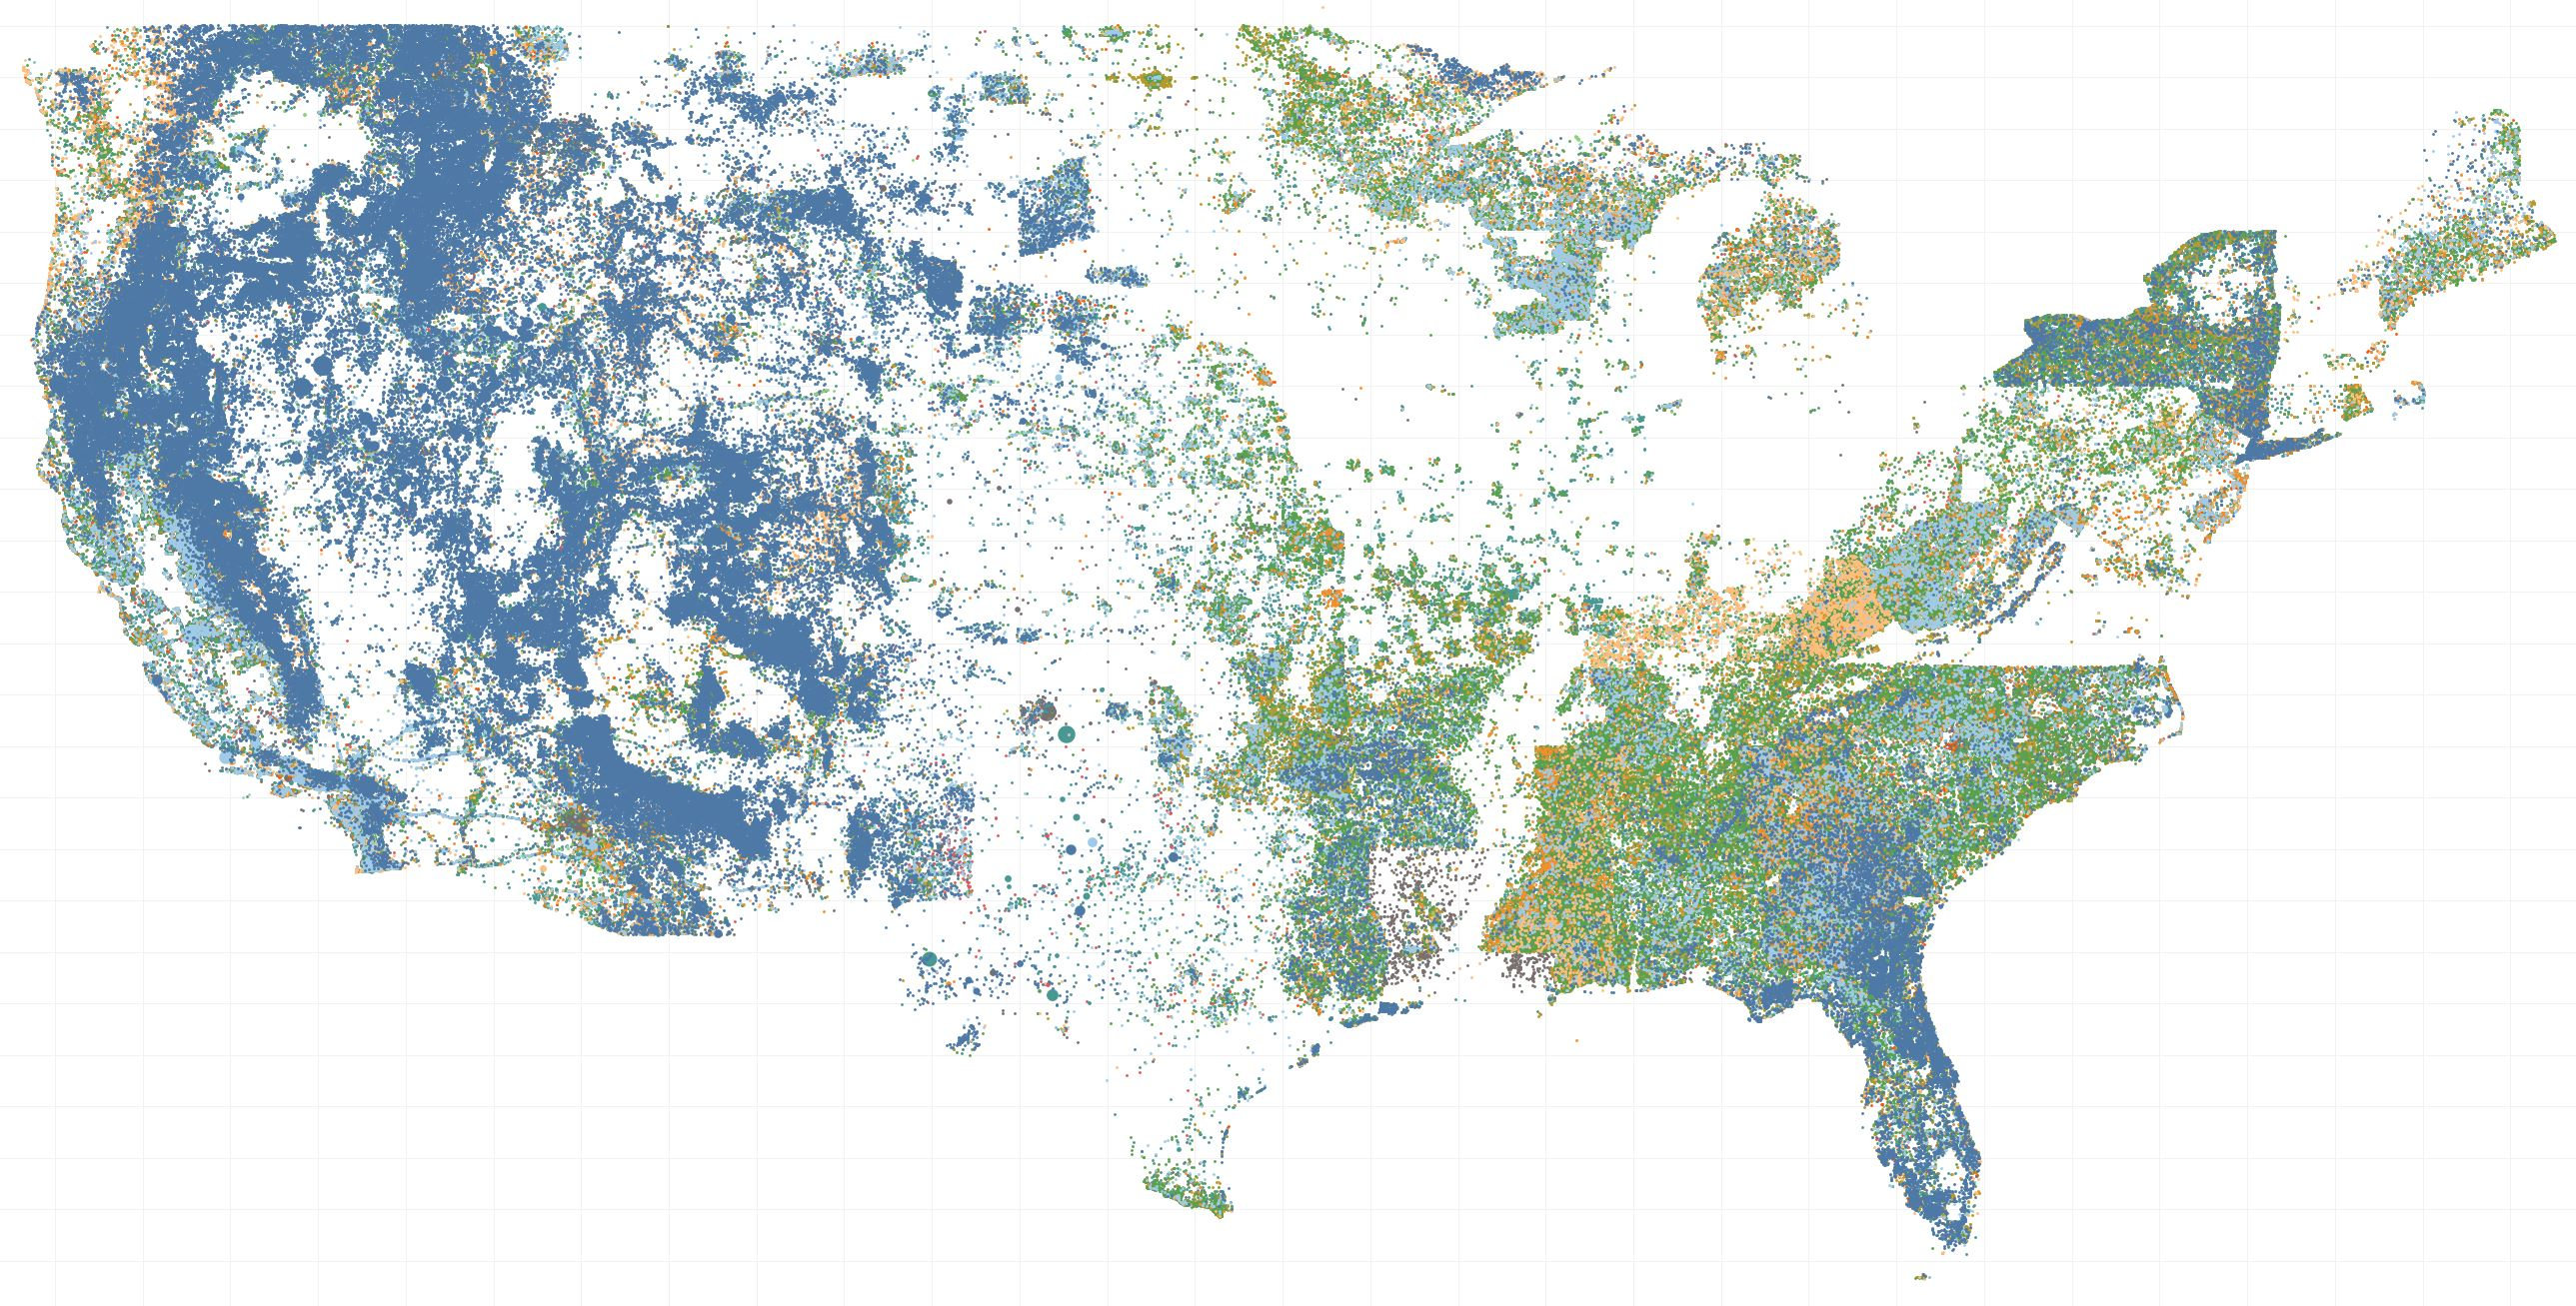

In [1]:
import os
from IPython.display import Image

Image(os.path.join('images', 'all_fires_map.JPG'))

Key to understanding the overall problem is the double-edged sword forests play in climate change; they are both a cause and effect. The wildfires both increase atmospheric greenhouse gasses and destroy the integral vegetation to the planet's carbon cycle [[3](https://www.iucn.org/resources/issues-briefs/forests-and-climate-change), [7](https://daac.ornl.gov/NPP/guides/NPP_EMDI.html), [8](http://daac.ornl.gov/)]. The Paris Agreement has specifically mentioned the importance of this and insists that countries protect against deforestation [[4](https://unfccc.int/process-and-meetings/the-paris-agreement/the-paris-agreement)]. Not only is the world pushing to keep the forests we have but here at home, we have begun to employ them as significant combatants in the fight against climate change. California has led the way with their proposed carbon plan. It proposes methods to reshape parts of their existing ecosystem to make their forests even more efficient at removing carbon [[5](http://www.unenvironment.org/news-and-stories/story/forests-provide-critical-short-term-solution-climate-change)]. Stopping deforestation would significantly promote the UNs progress towards reaching goals outlined in the Paris Agreement.

However, this will not work if the forests continue in the same destructive cycle with our ecosystem. The goal of this project is two-fold. One, to understand the independent variables and correlation effects in a combined dataset of the Fire Program Analysis (FPA) reporting system, NOAA's Global Surface Summary of Day Data (GSOD) 7, and  NASA's biomass indicators. Two, to train and assess a model for predicting the reason a wildfire started. (and possibly estimate the impact? location?) Identifying the source is a difficult task for investigators in the wild. The vastness of land covered is much larger than the matchstick or location of a lightning strike. Developing an understanding of the independent variables and a reliable prediction model could give authorities valuable direction as to where to begin their search.

#### Research Questions
* What are the most important indicators to consider when determining the cause of a wildfire?
* Can a reliable model be built to assist investigators in determining the cause of a wildfire?

####  Reproducibility
This notebook is intended to be completely reproducible. However, the starting datasets are much too large to be hosted on GitHub. I provide a small, randomly selected sample with the repository to show the dataset cleaning and generation process. If you run this notebook on your own machine please be aware that the notebook requires quite a bit of resources. With 12 cores running at 4ghz and a consistent 95% CPU load, it took my machine nearly 27 hours to compute. The analysis portion of the notebook is also computationally expensive. The cross-validation approach implemented will consume all available resources and severely limit any other concurrent processes for several hours. The final tuned models can be computed directly via the parameters found during my tuning process.

The original data format of the GSOD data makes creating samples a bit challenging. To do this, I ran an additional notebook with the following code. It opens each subdir of the extracted GSOD file and randomly selects and removes half the files. I ran this iteratively until the resulting file size was within the Github file size limit of 100mb.

```Python
import os

# walk the extracted directory
for dirpath, dirnames, filenames in os.walk('gsod_all_years'):
    
    # process each year
    for sdir in dirnames:
        # randomly select some station files        
        sfiles = os.listdir(os.path.join(dirpath, sdir))
        to_remove = np.random.choice(sfiles, int(len(sfiles)/2))
        
        # remove them
        for f in to_remove:
            try:
                tr = os.path.join('.', dirpath, sdir, f)
                os.remove(tr)
            except FileNotFoundError:
                pass
```

I repacked the sample to be in the same format as the original dataset using WinZip. To sample from the completed fires dataset I used the following code snippet.

```Python
import pandas as pd

# read
df = pd.read_csv('fires_complete.csv')

# sample
df = df.sample(frac=.85)

# write back
df.to_csv('fires_complete.csv', index=None)
```

And finally, to sample the fires data I first dropped all other tables besides Fires. Next, I ran the following snippet iteratively until the sqlite file was under 100mb.

```Python
import sqlite3

# connect
path = os.path.join('FPA_FOD_20170508.sqlite')
conn = sqlite3.connect(path)

# randomly delete some fires
conn.execute("""
  DELETE FROM Fires
  WHERE fod_id IN (
    SELECT fod_id
    FROM Fires 
    ORDER BY RANDOM() 
    LIMIT 100000
  );
""")

# compress the file
conn.execute('VACUUM;')
```

#### A Note on Visualizations
I use [Plotly](https://plot.ly/python/) extensively throughout this notebook. They are interactive and require Javascript to be running in the background. The Github previewer does not run the necessary Javascript for rendering making them just empty grey squares. 

#### The Full Datasets
The full datasets can be downloaded by changing the bool `fulldata` to True and running the following cell.

In [2]:
fulldata = False

if fulldata:
    import boto3
    import botocore

    bucket = 'waninger-hcds'
    
    fires_complete = 'fires_complete.csv'
    fires_original = 'FPA_FOD_20170508.sqlite'
    gsod_original  = 'gsod_all_years.zip'

    s3 = boto3.resource('s3')

    try:
        s3.Bucket(bucket).download_file(fires_complete, os.path.join('.', 'data', fires_complete))
        s3.Bucket(bucket).download_file(fires_original, os.path.join('.', 'data', fires_original))
        s3.Bucket(bucket).download_file(gsod_original,  os.path.join('.', 'data', gsod_original))
                                        
    except botocore.exceptions.ClientError as e:
        if e.response['Error']['Code'] == "404":
            print("The object does not exist.")
        else:
            raise

## Part 1. Data Preparation

### Setup
This notebook is coded to run with Python 3.6. Several libraries from the Python standard library will be used along with several third-party modules. These can be installed with the provided requirements file using the command 

`pip install --user -r requirements.txt`

More information regarding the standard libarary can be found at [python.org](https://docs.python.org/3.6/library/index.html).

For third party libraries please see:
* [numpy == 1.13.0](https://docs.scipy.org/doc/numpy-1.13.0/reference/)
* [pandas == 0.23.4](https://pandas.pydata.org/pandas-docs/stable/)
* [plotly == 3.4.2](https://plot.ly/python/)
* [scikit-learn == 0.20.1](https://scikit-learn.org/stable/documentation.html)
* [statsmodels == 0.9.0](https://www.statsmodels.org/stable/index.html)
* [tqdm == 4.28.1](https://github.com/tqdm/tqdm)

In [2]:
# Python standard library
import calendar
import datetime as dt
from IPython.core.interactiveshell import InteractiveShell
import itertools as it
import multiprocessing as mul
from multiprocessing.dummy import Pool as TPool
import gzip
import os
import shutil
import sqlite3
import sys
import tarfile
import time
import zipfile

# third party modules
import numpy as np
import pandas as pd
import plotly.graph_objs as go
from plotly import tools
import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode, iplot
from scipy import interp
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.preprocessing import label_binarize, LabelEncoder, StandardScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
from tqdm import tqdm, tqdm_pandas

# initialize plotly    
init_notebook_mode(connected=True)

# set notebook options
InteractiveShell.ast_node_interactivity = 'all'

# set random seed
np.random.seed(42)

# initalize tqdm
tqdm.pandas(leave=True)

### Data Sources
Four data sources are to be used for this project. The primary data source was found through Kaggle and contains 1.88 million wildfires that occurred in the United States from 1992 to 2015. This data contains the primary labels to be used as target variables. The United States Department of Agriculture curated the original data ([Forest Service](https://www.fs.fed.us/)) and can be found at [link](https://www.fs.usda.gov/rds/archive/Product/RDS-2013-0009.4/). The second is the GSOD data curated by [NOAA](https://www.noaa.gov/). Finally, the National Air and Space Association (NASA) hosts a valuable biome dataset at the ORNL Distributed Active Archive Center for Biogeochemical Dynamics ([DAAC](https://daac.ornl.gov/NPP/guides/NPP_EMDI.html). Later in the notebook, I will show how neither the NASA or DAAC data is useful and propose an alternate data source for future work.

### Get some metrics from the fires dataset
The target variable for this analysis exists inside the wildfire dataset. I start by generating a bounding box of latitude and longitude values to filter the other three sources.

In [4]:
# generate the file path and connect using the sqlite3 driver
path = os.path.join('.', 'data', 'FPA_FOD_20170508.sqlite')
conn  = sqlite3.connect(path)

# retrieving the minimum and maximum latitude and longitude pairs.
fires = pd.read_sql_query('''
    SELECT 
        min(LATITUDE)  AS min_lat,
        max(LATITUDE)  AS max_lat,
        min(LONGITUDE) AS min_lon,
        max(LONGITUDE) AS max_lon
    FROM
        Fires
''', conn)

# increase by one degree-decimal point so that we don't exclude 
# nearby weather stations
min_lat = np.round(fires.min_lat.values[0], 0)-1
min_lon = np.round(fires.min_lon.values[0], 0)-1
max_lat = np.round(fires.max_lat.values[0], 0)+1
max_lon = np.round(fires.max_lon.values[0], 0)+1

# print them to the console
min_lat, max_lat, min_lon, max_lon

(17.0, 71.0, -167.0, -64.0)

### Load and process GSOD files
The data from NOAA comes in a full-nonsense version. It's a collection zipped zip files, one compressed tar file for each year. Then, each day of the year and station is yet another compressed gzip file. I extract the main file and remove any years not from 1991-2015. In the next cell I unzip the years we need, then each year into the directory 'gsod_extracted'. I apologize for this next few cells. This really is nonsense to make it reproducible all the way from the source file from NOAA.

In [5]:
# create the file path
gsod_path = os.path.join('.', 'data', 'gsod')

# make sure the path exists
if not os.path.exists(gsod_path):
    os.mkdir(gsod_path)
    
# get the main zip file
all_years = zipfile.ZipFile(os.path.join('data','gsod_all_years.zip'))

# look for contents only in the designated year range
members   = [
    n for n in all_years.namelist() 
    if any([n.find(str(yi)) > -1 for yi in list(range(1991, 2016))])
]

# extract
for m in tqdm(members):
    t = all_years.extract(m, gsod_path)

100%|██████████| 12710/12710 [00:48<00:00, 259.95it/s]


Lets first load the listing of weather stations. I do this first because it reduces the number of operations of depending cells by quite a bit and in turn, drastically speeds up the notebook. Furthermore, I need the latitude and longitude values for each weather summary in order to join with the fires dataset. I do this by creating a composite key out of USAF and WBAN in both the stations and weather dataframes, then performing an inner join on it. For more information please see the NOAA data documentation provided. And finally, I need to create a smaller subset of the original dataset to reduce the amount of data we need to upload/download for reproducibility purposes.

I also make sure to exclude weather stations that aren't going to be used in widlfire feature engineering by creating latitude and longitude masks offsetting each min/max by 111km.

In [6]:
# load the stations file explicitly enforcing datatypes and nan values
# also drop any station that doesn't have a latitude or longitude value
stations = pd.read_csv(
    os.path.join('data', 'isd-history.csv'),
    dtype={
        'USAF':'str',
        'WBAN':'str'
    },
    na_values={
        'WBAN'   :'99999',
        'ELEV(M)':'-999'
    }
).dropna(subset=['LAT', 'LON'], how='any')

# take only stations that have lat, lon values within the wildfire range
stations['lat_mask'] = [min_lat <= lat <= max_lat for lat in stations.LAT]
stations['lon_mask'] = [min_lon <= lon <= max_lon for lon in stations.LON]
stations = stations.loc[stations.lat_mask & stations.lon_mask].drop(columns=['lat_mask', 'lon_mask'])

# create a key by concatenating the USAF and WBAN cols
stations.loc[stations.USAF.isnull(), 'USAF'] = 'none'
stations.loc[stations.WBAN.isnull(), 'WBAN'] = 'none'
stations['KEY'] = stations.USAF+stations.WBAN

# verify key uniqueness
assert len(stations.KEY.unique()) == len(stations)

# we will only be using these columns
stations = stations.reindex(columns=[
    'KEY', 'LAT', 'LON', 'ELEV(M)'
])

# rename the elevation column so we can call it easier
stations = stations.rename(columns={'ELEV(M)':'ELEV'})

# convert all the column names to lowercase
stations.columns = [c.lower() for c in stations.columns]

stations.head()

key     lat      lon    elev
9795    426409none  42.983  -89.750   370.0
14441   690014none  32.350 -106.367  1224.0
14442  69002093218  36.000 -121.233   317.0
14443   690020none  36.000 -121.233   317.0
14444  69007093217  36.683 -121.767    43.0

Now extract the contents of each year into the extracted directory.

In [7]:
# get the yearly list of tar files
years = [f for f in os.listdir(gsod_path) if f.find('tar') > -1]

# generate the extract path
ex_path = os.path.join('.', 'data', 'gsod_extracted')

# make sure the path exists
if not os.path.exists(ex_path):
    os.mkdir(ex_path)
    
# extract the content from each year into the 'extracted' directory
pbar = tqdm(total=len(years))
for y in years:
    pbar.set_description(y)
    
    # load the tarfile provided by NOAA
    tf = tarfile.TarFile(os.path.join(gsod_path, y))
    
    # create a subdirectory to extract the contents into
    subdir = os.path.join(ex_path, y.replace('.tar', ''))
    if not os.path.exists(subdir):
        os.mkdir(subdir)
    
    # extract each year
    tf.extractall(subdir)    
    pbar.update(1)
    
# otherwise this is the sampled data so just move the contents
if len(years) == 0:
    years = os.listdir(gsod_path)
    for y in years:
        files = os.listdir(os.path.join(gsod_path, y))
        for f in files:
            old = os.path.join(gsod_path, y, f)
            
            newdir = os.path.join(ex_path, y)
            if not os.path.exists(newdir):
                os.mkdir(newdir)

            new = os.path.join(newdir, f)
            os.rename(old, new)
        pbar.update(1)
pbar.close()

25it [00:10,  1.83it/s]


Process each station file line-by-line into DataFrame. This cell only does the raw transformation from a gzip text file into a csv. Each line of each file is a separate row with each field separated by a certain number of character positions. These are listed in the NOAA GSOD docs and were extensively used to process the data. Note, the extractions do not line up perfectly due to the parser being used. Each column was carefully checked to ensure no missing characters. Also of note is that some of the files contain blank lines so I added a filter at the end of each parsing to only input the row if a valid station id is present. We can't perform the latitude, longitude lookup without it making the row unusable even if it did contain the remaining fields.

In [8]:
# get the list of files for each day
ex_path = os.path.join('.', 'data', 'gsod_extracted')
years = [d for d in os.listdir(ex_path) if os.path.isdir(os.path.join(ex_path, d))]

# read and extract the contents for each day of year
i=0
for y in years:
    # create the filename to save the final csv output
    name = os.path.join(ex_path, y.replace('.tar', ''))
    name = name + '.csv'
    
    # get the subdirectory path
    subdir = os.path.join(ex_path, y.replace('.tar', ''))
    
    # read all files we extracted into the directory
    files = os.listdir(subdir)
    
    # store a list of dictionary objects for each row parsed
    content = []

    for f in tqdm(files, desc=y):
        # open the file
        with gzip.open(os.path.join(subdir, f), 'r') as fc:
            # read the entire contents, split by newline and ignore header
            t = str(fc.read()).split('\\n')[1:]

            # see GSOD_DESC.txt for exact delimmiter locations
            def parse(s):
                d = dict(
                    stn      = s[ 0: 6].strip(),
                    wban     = s[ 6:13].strip(),
                    year     = s[13:18].strip(),
                    moda     = s[18:23].strip(),
                    temp     = s[23:30].strip(),
                    temp_cnt = s[30:34].strip(),
                    dewp     = s[34:41].strip(),
                    dewp_cnt = s[41:44].strip(),
                    slp      = s[44:52].strip(),
                    slp_cnt  = s[52:55].strip(),
                    stp      = s[55:63].strip(),
                    stp_cnt  = s[63:66].strip(),
                    visib    = s[67:73].strip(),
                    visib_cnt= s[73:76].strip(),
                    wdsp     = s[76:83].strip(),
                    wdsp_cnt = s[83:86].strip(),
                    mxspd    = s[88:93].strip(),
                    gust     = s[94:101].strip(),
                    temp_max = s[102:108].strip(),
                    max_temp_flag = s[108:110].strip(),
                    temp_min = s[111:116].strip(),
                    min_temp_flag = s[116:117].strip(),
                    prcp     = s[117:123].strip(),
                    prcp_flag= s[123:124].strip(),
                    sndp     = s[124:131].strip(),
                    frshtt   = s[131:138].strip()
                )
                
                return d if len(d['stn']) > 1 else None

            # convert each row into a dictionary using the function above
            # and append the contents to the main collection
            content += list(map(parse, t))
    
    # convert the list of dictionaries to a Pandas dataframe
    content = pd.DataFrame([c for c in content if c is not None])
    
    # write this years worth of weather recordings to csv
    content.to_csv(name, index=None)                                

gsod_2015: 100%|██████████| 681/681 [00:02<00:00, 295.88it/s]


In the following cell, I go through the csv contents we generated above. Specific datatypes are enforced to prevent Pandas from dropping leading zeroes, for example, and to make additional operations more streamlined. Each will be explained line by line.

In [9]:
# get the list of yearly weather files
ex_path = os.path.join('.', 'data', 'gsod_extracted')
names = [f for f in os.listdir(ex_path) if 'csv' in f]

# process each year at a time
pbar = tqdm(total=len(names))
for name in names:
    pbar.set_description(name)
    
    # load the data, setting data types explicitly or pandas will drop 
    # the leading zeroes needed for station names. Also, include the 
    # explicit na values designated in the data documentation
    # drop columns we aren't going to use
    f1 = pd.read_csv(
            os.path.join(ex_path, name), 
            dtype={
                'stn' :'str', 
                'wban':'str',
                'moda':'str',
                'frshtt':'str',
                'year':'str'},
            na_values={
                'stn'  :'999999',
                'wban' :'99999',
                'temp' :'9999.9',
                'dewp' :'9999.9',
                'slp'  :'9999.9',
                'stp'  :'9999.9',
                'visib':'999.9',
                'wdsp' :'999.9',
                'mxspd':'999.9',
                'gust' :'999.9',
                'max_temp':'9999.9',
                'min_temp':'9999.9',
                'prcp':'99.9',        
                'sndp':'999.9'},
        ) \
        .drop(columns=[
            'max_temp_flag', 'min_temp_flag', 
            'temp_cnt', 'dewp_cnt', 'slp_cnt', 
            'stp_cnt', 'visib_cnt', 'wdsp_cnt'])

    # convert the two date columns 'year' and 'moda' to a single pydate
    f1['date'] = [
        dt.datetime(year=int(r.year), month=int(r.moda[:2]), day=int(r.moda[2:])) 
        for r in f1.itertuples()
    ]
    
    # extract month number and julian date
    f1['month'] = f1.date.apply(lambda x: x.month)
    f1['doy'] = f1.date.apply(lambda x: x.timetuple().tm_yday)

    # convert prcp values to na where prcp flag is in {'H', 'I'}. see the data docs
    f1.loc[(f1.prcp_flag == 'H') | (f1.prcp_flag == 'I'), 'prcp'] = np.nan

    # convert 'frshtt' to an ordinal value based on severity where the
    # returned value is the number of leading most 1. ie. 010000 -> 2
    # 1:fog, 2:rain, 3:snow, 4:hail, 5:thunderstorm, 6:tornado
    def fx(x):
        x = x[::-1].find('1')
        return x if x != -1 else 0

    f1['atmos_sev'] = f1.frshtt.apply(fx)
    
    # create the join key in the same way as we did for weather stations
    f1.loc[f1.stn.isnull(), 'stn'] = 'none'
    f1.loc[f1.wban.isnull(), 'wban'] = 'none'
    f1['key'] = f1.stn + f1.wban
    
    # perform an inner join with stations
    f1 = f1.merge(stations, on='key', how='inner')
    
    # reorder the columns, dropping the ones that won't be used
    prefix = ['lat', 'lon', 'year', 'month', 'doy']
    f1 = f1.reindex(columns=prefix + sorted(list(
        set(f1.columns) - set(prefix) - {
            'moda', 'prcp_flag', 'frshtt', 'stn', 'wban', 'key', 'date'
        }
    )))
    
    # write the cleaned dataframe to disk
    name = os.path.join(gsod_path, name.replace('.csv', '_cleaned') + '.csv')
    f1.to_csv(name, index=None)
    
    pbar.update(1)
pbar.close()

gsod_2015.csv: 100%|██████████| 25/25 [01:09<00:00,  3.86s/it]


Create a single data frame with cleaned values for all years. This generates a dataframe approximately 1.7gb uncompressed which is a significant reduction from the 3.4gb original compressed file.

In [10]:
# get the list of cleaned files
files = [f for f in os.listdir(gsod_path) if 'cleaned.csv' in f]
assert len(files) == 25

gsod = pd.concat([pd.read_csv(os.path.join(gsod_path, f)) for f in files])
gsod.to_csv(os.path.join('.', 'data', 'gsod.csv'), index=None)

In [11]:
# cleanup the temp directories
gsod_path = os.path.join('.', 'data', 'gsod')
shutil.rmtree(gsod_path)

ex_path = os.path.join('.', 'data', 'gsod_extracted')
shutil.rmtree(ex_path)

### Clean the fires dataset
This dataset comes relatively clean. The only modifications we'll be doing is removing the columns we won't be using, creating a few new, and reordering them for convenience.

In [13]:
# generate the path and connect to the sqlite fires file
path = os.path.join('.', 'data', 'FPA_FOD_20170508.sqlite')
conn  = sqlite3.connect(path)

# read all the columns we need
fires = pd.read_sql_query('''
    SELECT FOD_ID,
        FIRE_YEAR, DISCOVERY_DOY, DISCOVERY_TIME,
        STAT_CAUSE_CODE, CONT_DOY, CONT_TIME,
        FIRE_SIZE, LATITUDE, LONGITUDE, OWNER_CODE,
        STATE
    FROM
        Fires;
''', conn)

# convert column names to lowercase
fires.columns = [c.lower() for c in fires.columns]

# based on the first 10000 rows, 0.35% have missing containment values which is a 
# negligible loss at this point in the analysis
fires = fires.dropna(subset=[
    'discovery_doy', 'discovery_time', 'cont_doy', 'cont_time'
], how='any')

# convert fire_year, discovery doy, and time to pydate
fires['dt_disc'] = [
    dt.datetime(year=int(r.fire_year), 
                month=1, 
                day=1, 
                hour=int(r.discovery_time[:2]),
                minute=int(r.discovery_time[2:])
               ) + \
    dt.timedelta(days=r.discovery_doy)
    for r in fires.itertuples()
]

# convert the containment dates
fires['dt_cont'] = [
    dt.datetime(year=int(r.fire_year), month=1, day=1, hour=int(r.cont_time[:2]), minute=int(r.cont_time[2:])) + \
    dt.timedelta(days=r.cont_doy)
    for r in fires.itertuples()
]

# create some higher resolution columns
def seconds_into_year(x):
    a = dt.datetime(year=x.year, month=1, day=1, hour=0, minute=0, second=0)
    return int((x-a).total_seconds())

def seconds_into_day(x):
    a = dt.datetime(year=x.year, month=x.month, day=x.day, hour=0, minute=0, second=0)
    return (x-a).seconds

# calculate fire duration in seconds, but only if the contained date is
# later than the start date
fires['disc_soy'] = fires.dt_disc.progress_apply(seconds_into_year)
fires['cont_soy'] = fires.dt_cont.progress_apply(seconds_into_year)
fires['duration'] = [
    r.cont_soy-r.disc_soy 
    if r.cont_soy > r.disc_soy else np.nan
    for r in tqdm(fires.itertuples(), total=len(fires))
]

# extract month and hour as new columns
fires['date']  = fires.dt_disc.progress_apply(lambda x: x.date())
fires['month'] = fires.dt_disc.progress_apply(lambda x: x.month)
fires['dow']   = fires.dt_disc.progress_apply(lambda x: x.weekday())
fires['hod']   = fires.dt_disc.progress_apply(lambda x: x.hour)
fires['sod']   = fires.dt_disc.progress_apply(seconds_into_day)

# encode the state
state_le = LabelEncoder()
fires['state'] = state_le.fit_transform(fires.state)

# drop some columns we won't be using
fires = fires.drop(columns=[
    'discovery_time', 'cont_doy', 'cont_time', 
    'disc_soy', 'cont_soy', 'dt_cont', 
    'dt_disc'
])

# rename some columns
fires = fires.rename(columns={
    'discovery_doy':'doy',
    'latitude':'lat',
    'longitude':'lon',
    'fire_year':'year',
    'stat_cause_code':'cause_code',
})

# reorder the columns
prefix = ['fod_id', 'lat', 'lon', 'date', 'year', 'month', 'doy', 'dow', 'hod', 'sod']
fires = fires.reindex(columns=prefix + sorted(list(
    set(fires.columns) - set(prefix)
)))

fires.head()

100%|██████████| 382627/382627 [00:07<00:00, 50829.50it/s]


fod_id        lat         lon        date  year  month  doy  dow  hod  \
0       2  38.933056 -120.404444  2004-05-13  2004      5  133    3    8   
1       6  38.635278 -120.103611  2004-07-01  2004      7  182    3   18   
2       8  40.968056 -122.433889  2005-03-09  2005      3   67    2   13   
3       9  41.233611 -122.283333  2005-03-16  2005      3   74    2   12   
4      15  38.675833 -120.279722  2004-10-04  2004     10  277    0    6   

     sod  cause_code  duration  fire_size  owner_code  state  
0  31500         1.0     24300       0.25         5.0      4  
1  64800         1.0     79200       0.10         5.0      4  
2  46800         5.0     10800       0.80        13.0      4  
3  43200         5.0     18000       1.00        13.0      4  
4  23400         1.0     30600       0.20         5.0      4

A possible feature we can engineer is the number of nearby fires. You can see the relation by looking at the first couple of rows in the fires table shown above. We see two fires occur on the same day that almost look like duplicates except they're separated by a few kilometers. This can be an especially strong signal for both lightning and arson related fires. 

This many lookups becomes a compute intensive operation and can take many hours to complete if run iteratively. In the following cell I create subsets of the main fires index. Each subset is sent to a different process where thread pools operate in parallel on the assigned subset. The results are output to separate csv files linked with the fire_id. This precludes transferring the data back from the assigned CPU. Instead, I'll read and join the new feature from disk in the next cell. This compute plan reduced the estimated time to completion from roughly 15 hours to 45 minutes on my local machine.

In [14]:
# thread task
def nearby_count(f, qu):
    # lookup any fires within 55km
    nearby = fires.loc[
        (fires.year == f.year) & (fires.doy == f.doy) &
        (fires.lat <= f.lat + .25) & (fires.lat >= f.lat - .25) &
        (fires.lon <= f.lon + .25) & (fires.lon >= f.lon - .25)
    ]
    
    # update progress
    qu.put(1)
    
    # return the fire id and count
    return dict(fod_id=f.fod_id, nearby=len(nearby)-1)

# process task
def px(batch, fires, start, step, qu):
    nearby = list(fires.iloc[start:start+step, :].apply(nearby_count, axis=1, qu=qu))
    
    path = os.path.join('.', 'data', f'nearby_{batch}.csv')
    pd.DataFrame(nearby).to_csv(path, index=None)

# number of shards or 'batches'
batches = 6    

# a container to hold each process
processes = []

# compute the step size
step = int(len(fires)/batches)+1

# setup a progress bar and update queue
pbar = tqdm(total=len(fires))
qu = mul.Queue()

# create the subsets and dish out the processor tasks
for batch in range(batches):
    # calculate the starting point for this subset
    start = step*batch
    
    # create, append, and start the child process
    p = mul.Process(target=px, args=(batch, fires, start, step, qu))
    processes.append(p)
    p.start()

# continue until the children finish
complete = False
while not complete:
    running = batches
    
    # round robin check of child state
    for p in processes:
        if not p.is_alive():
            running -= 1
    
    # set completion status if all are finished
    if running == 0:
        complete = True
    
    # empty the update qu
    while not qu.empty():
        t = qu.get()
        pbar.update(t)
    
# terminate and join all the children
for p in processes:
    p.terminate()
    p.join()

100%|█████████▉| 382621/382627 [08:33<00:00, 238.45it/s]

In [15]:
# read the batches into one frame
path = os.path.join('.', 'data')
nearby = pd.concat([
    pd.read_csv(os.path.join(path, f)) 
    for f in os.listdir(path) if 'nearby_' in f
], sort=False)

# merge with the main and make sure we didn't lose any rows
a = len(fires)
fires = fires.merge(nearby, on='fod_id', how='inner')
assert a == len(fires)

# print
fires.head()

fod_id        lat         lon        date  year  month  doy  dow  hod  \
0       2  38.933056 -120.404444  2004-05-13  2004      5  133    3    8   
1       6  38.635278 -120.103611  2004-07-01  2004      7  182    3   18   
2       8  40.968056 -122.433889  2005-03-09  2005      3   67    2   13   
3       9  41.233611 -122.283333  2005-03-16  2005      3   74    2   12   
4      15  38.675833 -120.279722  2004-10-04  2004     10  277    0    6   

     sod  cause_code  duration  fire_size  owner_code  state  nearby  
0  31500         1.0     24300       0.25         5.0      4       1  
1  64800         1.0     79200       0.10         5.0      4       0  
2  46800         5.0     10800       0.80        13.0      4       0  
3  43200         5.0     18000       1.00        13.0      4       0  
4  23400         1.0     30600       0.20         5.0      4       2

In [16]:
# cleanup temporary files
files = [
    os.remove(os.path.join('data', f)) 
    for f in os.listdir('data') if 'nearby_' in f
]

Lets take a quick look at the only categorical variable we have - OWNER_CODE.

In [17]:
# generate the path and connect to the sqlite fires file
path = os.path.join('.', 'data', 'FPA_FOD_20170508.sqlite')
conn  = sqlite3.connect(path)

# get the mapping of cause codes to description
owners = pd.read_sql_query('''
    SELECT DISTINCT(OWNER_CODE), OWNER_DESCR
    FROM Fires;
''', conn)\
    .sort_values('OWNER_CODE')

# rename the columns and set the index to code
owners = owners.rename(columns={
    'OWNER_CODE':'code',
    'OWNER_DESCR':'owner'
}).set_index('code')

# get the counts of each cause
bincounts = fires.owner_code.value_counts()

# plot
iplot(go.Figure(
    [go.Bar(
        x=[owners.loc[idx].owner for idx in bincounts.index],
        y=bincounts,
        text=bincounts.index,
        textposition='outside'
    )],
    go.Layout(
        title='Distribution of owners',
        yaxis=dict(title='Count of owned fires')
    )
))

This isn't our target variable but there are clear commonalities we can take advantage of to boost any signal that may come from the responsible land owner. To help understand this a bit better here is the list of federal acronyms:

* USFS - United States Forest Service
* BIA - Bureau of Indian Affairs
* BLM - Bureau of Land Management
* NPS - National Park Service
* FWS - Fish and Wildlife Service
* BOR - Bureau of Reclamation

Here is a list of things I notice from the visualization.
1. UNDEFINED FEDERAL has very little values and can be combined with OTHER FEDERAL. 
2. COUNTY owned land can be joined with MUNICIPAL/LOCAL.
3. STATE OR PRIVATE can be separted into the STATE and PRIVATE categories. To do this, I'll draw from a random binomial distribution characterized by the ratio between the two.
4. TRIBAL can be combined with BIA and I'll rename it to Native American.
5. Move the FOREIGN items into MISSING/NOT SPECIFIED.
6. Move the MUNICIPAL/LOCAL government owned into STATE owned.
7. Group the lower represented federal agencies into the FEDERAL category.

This recategorization plan reduces the number of categories from 16 to six which will signficantly boost signal strength and keep the feature space more manageable. I also plan on renaming a few before continuing. Additionally, we'll need to store the new owner descriptions so we preserve the recategorization mapping.

In [ ]:
# recategorize UNDEFINED FEDERAL
fires.loc[fires.owner_code == 15, 'owner_code'] = 6

# recategorize the under represented federal agencies - BLM, NPS, FWS, BOR
fires.loc[[True if o in [1, 3, 4, 10] else False for o in fires.owner_code], 'owner_code'] = 6

# rename the federal category
owners.loc[6, 'owner'] = 'FEDERAL'

# recategorize COUNTY
fires.loc[fires.owner_code == 11, 'owner_code'] = 12
owners.loc[12, 'owner'] = 'LOCAL'

# recategorize STATE OR PRIVATE
den = (bincounts[8]+bincounts[7])
p = bincounts[8]/den

fires.loc[fires.owner_code == 13, 'owner_code'] = np.random.binomial(1, p, len(fires.loc[fires.owner_code == 13]))+7

# recategorize TRIBAL
fires.loc[fires.owner_code == 9, 'owner_code'] = 2
owners.loc[2, 'owner'] = 'NATIVE_AMERICAN'

# recategorize FOREIGN
fires.loc[fires.owner_code == 0, 'owner_code'] = 14
owners.loc[14, 'owner'] = 'OTHER'

# recategorize MUNICIPAL/LOCAL
fires.loc[fires.owner_code == 12, 'owner_code'] = 7

# drop the integer encoding in favor of the new names
# create the new column
fires['owner'] = 'none'

# reformat the owners description to lowercase
owners.owner = [o.lower() for o in owners.owner]

# assign each code the representative name
for code in fires.owner_code.unique():
    fires.loc[fires.owner_code == code, 'owner'] = owners.loc[code].owner

# drop the original encoded column
fires = fires.drop(columns=['owner_code'])

Let's replot the categorical distribution to show the differences we've made for the owner's category.

In [ ]:
# get the counts of each cause
bincounts = fires.owner.value_counts()

# plot as a bar plot
iplot(go.Figure(
    [go.Bar(
        x=bincounts.index,
        y=bincounts,
        text=bincounts,
        textposition='inside'
    )],
    go.Layout(
        title='Distribution of owners',
        yaxis=dict(title='Count of owned fires')
    )
))

Finally, write the completed fires dataframe to disk.

In [ ]:
fires.to_csv(os.path.join('.', 'data', 'fires_cleaned.csv'), index=None)
fires.head()

fod_id        lat         lon        date  year  month  doy  dow  hod  \
0       2  38.933056 -120.404444  2004-05-13  2004      5  133    3    8   
1       6  38.635278 -120.103611  2004-07-01  2004      7  182    3   18   
2       8  40.968056 -122.433889  2005-03-09  2005      3   67    2   13   
3       9  41.233611 -122.283333  2005-03-16  2005      3   74    2   12   
4      15  38.675833 -120.279722  2004-10-04  2004     10  277    0    6   

     sod  cause_code  duration  fire_size  state  nearby    owner  
0  31500         1.0     24300       0.25      4       1     usfs  
1  64800         1.0     79200       0.10      4       0     usfs  
2  46800         5.0     10800       0.80      4       0  private  
3  43200         5.0     18000       1.00      4       0    state  
4  23400         1.0     30600       0.20      4       2     usfs

### Process ORNL features
Each station has a center point and provides the coverage data in both 1km and 50km pixel grids surrounding the station. My first approach to joining the fires and ground cover data was to include any predictions within the station's bounding box but, this led to incredibly sparse results. I leave the cell blocks here to both show my process and why I'm no longer using the data source. In the following cell I load both high and low quality datasets.

In [ ]:
# load the data we'll use, enforce datatypes, and rename columns
cover = pd.concat([
    pd.read_csv(
        os.path.join('.', 'data', f),
        usecols=[
            'LAT_DD', 'LONG_DD', 'COVR1KM', 'COVR50KM'
        ],
        dtype={
            'COVR1KM':'str',
            'COVR50KM':'str'
        }
    ).rename(columns={
        'LAT_DD':'LAT',
        'LONG_DD':'LON'
    })
    for f in [
        'EMDI_ClassA_Cover_UMD_81.csv',
        'EMDI_ClassB_Cover_UMD_933.csv'
    ]
], sort=False)
    
# convert columns to lowercase
cover.columns = [c.lower() for c in cover.columns]

# create cover 50k grid boundaries
cover['lower50_lat'] = cover.lat.apply(lambda x: x-.5)
cover['upper50_lat'] = cover.lat.apply(lambda x: x+.5)
cover['lower50_lon'] = cover.lon.apply(lambda x: x-.5)
cover['upper50_lon'] = cover.lon.apply(lambda x: x+.5)

# only include the values within the fire bounding box
cover = cover.loc[
    (cover.lower50_lat >= min_lat) & (cover.upper50_lat <= max_lat) &
    (cover.lower50_lon >= min_lon) & (cover.upper50_lon <= max_lon)
]

cover.head()

lat     lon covr1km covr50km  lower50_lat  upper50_lat  lower50_lon  \
34  18.30  -65.70       7        2        17.80        18.80       -66.20   
35  19.46  -98.91      10       11        18.96        19.96       -99.41   
36  19.50 -105.05       6        6        19.00        20.00      -105.55   
38  32.60 -106.85       9        9        32.10        33.10      -107.35   
39  35.30 -101.53      10       10        34.80        35.80      -102.03   

    upper50_lon  
34       -65.20  
35       -98.41  
36      -104.55  
38      -106.35  
39      -101.03

Plot a sample of fires and the bounding boxes for each station to show just how inadequate the ORNL dataset is. Each point represents a fire with the size of the fire mapped to the size of the point.

In [ ]:
# extract a uniform sample of 2k fires
sample = fires.sample(5000)

# generate scatter plot points
fire_trace = go.Scatter(
    x=sample.lon, 
    y=sample.lat,
    mode='markers',
    marker=dict(        
        color='#571C00'
    )
)

# generate the bounding boxes
shapes = [
    {
        'type':'rect',
        'x0':r.lower50_lon,
        'x1':r.upper50_lon,
        'y0':r.lower50_lat,
        'y1':r.upper50_lat,
        'fillcolor':'rgba(22, 74, 40, .4)',
        'line':{
            'width':.1
        }
    }
    for r in cover.itertuples()
]

# plot
iplot(go.Figure(
    [fire_trace],
    layout=go.Layout(
        shapes=shapes,
        xaxis=dict(
            title='longitude',
            range=[-125, -78]
        ),
        yaxis=dict(
            title='latitude',
            range=[25, 58]
        ),
        title='Ground cover data coverage is insufficient',
        width=1200,
        height=800
    )
))

The same goes for soil content because the same stations are used for this dataset.

In [ ]:
# load the data
soil = pd.concat([
    pd.read_csv(
        os.path.join('.', 'data', f)
    ).rename(columns={
        'LAT_DD':'LAT',
        'LONG_DD':'LON'
    }).drop(columns='SITE_ID')
    for f in [
        'EMDI_ClassA_Soil_IGBP_81.csv',
        'EMDI_ClassB_Soil_IGBP_933.csv'
    ]
], sort=False)

# convert columns to lowercase
soil.columns = [c.lower() for c in soil.columns]

# create the station bounding box
soil['lower50_lat'] = soil.lat.apply(lambda x: x-.5)
soil['upper50_lat'] = soil.lat.apply(lambda x: x+.5)
soil['lower50_lon'] = soil.lon.apply(lambda x: x-.5)
soil['upper50_lon'] = soil.lon.apply(lambda x: x+.5)

# only include the values within the fire bounding box
soil = soil.loc[
    (soil.lower50_lat >= min_lat) & (soil.upper50_lat <= max_lat) &
    (soil.lower50_lon >= min_lon) & (soil.upper50_lon <= max_lon)
]

soil.head()

lat     lon  sand  silt  clay  soiln30  soiln20  soiln100  soilc30  \
34  18.30  -65.70    45    28    28      474      333      1235     5.25   
35  19.46  -98.91    49    37    14      860      643      2199    11.52   
36  19.50 -105.05    32    29    39      621      451      1637     6.91   
38  32.60 -106.85    67    20    14      149      104       459     1.61   
39  35.30 -101.53    47    34    19      773      516      1752     7.08   

    soilc20  soilc100   ph    bd   fc  wp  pawc  lower50_lat  upper50_lat  \
34     3.83     11.03  6.1  1.38  133  52    80        17.80        18.80   
35     8.24     26.79  6.0  0.97  133  46    87        18.96        19.96   
36     5.13     16.82  6.6  1.42  136  64    72        19.00        20.00   
38     1.11      4.34  7.4  1.59  111  32    79        32.10        33.10   
39     4.72     14.95  7.6  1.27  129  45    84        34.80        35.80   

    lower50_lon  upper50_lon  
34       -66.20       -65.20  
35       -99.41       -98.41  
36      -105.55      -104.55  
38      -107.35      -106.35  
39      -102.03      -101.03

In [ ]:
# extract a fire sample
sample = fires.sample(5000)

# generate the fire scatter points
fire_trace = go.Scatter(
    x=sample.lon, 
    y=sample.lat,
    mode='markers',
    marker=dict(
        color='#571C00'
    )
)

shapes = [
    {
        'type':'rect',
        'x0':r.lower50_lon,
        'x1':r.upper50_lon,
        'y0':r.lower50_lat,
        'y1':r.upper50_lat,
        'fillcolor':'rgba(22, 74, 40, .4)',
        'line':{
            'width':.1
        }
    }
    for r in soil.itertuples()
]

# plot
iplot(go.Figure(
    [fire_trace],
    layout=go.Layout(
        shapes=shapes,
        xaxis=dict(
            title='longitude',
            range=[-125, -78]
        ),
        yaxis=dict(
            title='latitude',
            range=[25, 58]
        ),
        title='Soil data coverage is insufficient',
        width=1200,
        height=800
    )
))

An alternative data source for land coverage is available for public use. See the [Earth Engine Data Catalog](https://developers.google.com/earth-engine/datasets/catalog/)

### Generate aggregate weather features associated with each fire
We'll need to lookup all reports within a given bounding box centered at the fire's originating location. I use a bounding box to preclude performing pairwise distance lookups which might be more accurate but will incur a significant expense - $O(n^2)$. The embedded hierarchical structure within a degree-decimal formatted coordinate allows us to generate contextually important containment boundaries. The boundaries will include aggregated values from all weather reports $\pm$ 55.5km of the fire.

This is the long running computation may take several days to complete. I wrote it to perform aggregations in batches. Each batch will cache the resulting features to a csv file and continue with the next. Also of note here is that I use a single thread pool rather than the sharding technique to keep memory usage as low as possible.

In [3]:
# load cleaned GSOD file
gsod = pd.read_csv(os.path.join('.', 'data', 'gsod.csv'))
gsod.head()

lat     lon  year  month  doy  atmos_sev  dewp   elev  gust  mxspd  \
0  42.608 -82.835  1991      1    2          0   0.1  177.0   NaN    4.1   
1  42.608 -82.835  1991      1    3          0   1.7  177.0   NaN    5.1   
2  42.608 -82.835  1991      1    7          5  26.9  177.0   NaN    4.1   
3  42.608 -82.835  1991      1    8          3  26.4  177.0   NaN    2.9   
4  42.608 -82.835  1991      1    9          3  20.6  177.0   NaN    2.9   

   prcp     slp  sndp  stp  temp  temp_max  temp_min  visib  wdsp  
0   0.0  1036.5   NaN  NaN  11.8      27.1     -10.1   46.1   2.3  
1   0.0  1031.9   NaN  NaN   9.5      32.0      -7.2   46.4   1.6  
2   0.0  1024.8   NaN  NaN  30.0      39.0      21.9   23.0   1.9  
3   0.0  1024.2   NaN  NaN  28.3      33.1      21.9    6.1   2.0  
4   0.0  1022.1   NaN  NaN  22.6      29.1      18.0    8.7   1.9

In [4]:
# load the cleaned fires
fires = pd.read_csv(os.path.join('.', 'data', 'fires_cleaned.csv'), parse_dates=['date'])

# start a thread pool and progress bar
pool = TPool(mul.cpu_count())
pbar = tqdm(total=len(fires))

def weather_agg(args):    
    try:
        # extract the tuple arguments
        fod_id, lat, lon, year, doy = args
        
        # make a copy of the empty record to start this record with
        results = empty.copy()
        results['fod_id'] = fod_id
        
        # get all weather reports within 111km
        lat_min, lat_max = lat-.5, lat+.5
        lon_min, lon_max = lon-.5, lon+.5
        
        # retrieve all weather reports within the box and 4 days leading up to and including
        # the day of the fire
        wthr = gsod.loc[
            (gsod.lat >= lat_min) & (gsod.lat <= lat_max) &
            (gsod.lon >= lon_min) & (gsod.lon <= lon_max) &
            (
                (gsod.year == year) & (gsod.doy >= doy-4) & (gsod.doy <= doy) |
                (gsod.doy <= 4) & (gsod.year == year-1) & (gsod.doy >= 361+doy)
            )
        ]
        
        # get the three day prior aggregates
        w_ = wthr.loc[wthr.doy != doy]
        if len(w_) > 0:
            results['threeDay_atmos_sev'] = np.mean(w_.atmos_sev)
            results['threeDay_temp_max']  = np.max(w_.temp_max)
            results['threeDay_temp_min']  = np.min(w_.temp_min)
            results['threeDay_temp']  = np.median(w_.temp)
            results['threeDay_sndp']  = np.median(w_.sndp)
            results['threeDay_dewp']  = np.median(w_.dewp)
            results['threeDay_gust']  = np.max(w_.gust)
            results['threeDay_mxspd'] = np.max(w_.mxspd)
            results['threeDay_stp']   = np.median(w_.stp)
            results['threeDay_temp']  = np.median(w_.temp)
            results['threeDay_slp']   = np.median(w_.slp)
            results['threeDay_wdsp']  = np.median(w_.wdsp)
            results['threeDay_prcp']  = np.sum(w_.prcp)
            results['threeDay_visib'] = np.median(w_.visib)   

        # get the dayOf aggregates   
        w_ = wthr.loc[wthr.doy == doy]
        if len(w_) > 0:            
            results['dayOf_atmos_sev'] = np.mean(w_.atmos_sev)
            results['dayOf_temp_max']  = np.max(w_.temp_max)
            results['dayOf_temp_min']  = np.min(w_.temp_min)
            results['dayOf_temp']  = np.median(w_.temp)
            results['dayOf_sndp']  = np.median(w_.sndp)
            results['dayOf_dewp']  = np.median(w_.dewp)
            results['dayOf_gust']  = np.max(w_.gust)
            results['dayOf_mxspd'] = np.max(w_.mxspd)
            results['dayOf_stp']   = np.median(w_.stp)
            results['dayOf_temp']  = np.median(w_.temp)
            results['dayOf_slp']   = np.median(w_.slp)
            results['dayOf_wdsp']  = np.median(w_.wdsp)
            results['dayOf_prcp']  = np.median(w_.prcp)
            results['dayOf_visib'] = np.median(w_.visib)   
    
    # catch all exceptions and continue gracefully but make sure we
    # notify in case any occur
    except Exception as e:
        exc_type, exc_obj, exc_tb = sys.exc_info()
        print(exc_type, e, exc_tb.tb_lineno)
    
    pbar.update(1)
    return results

# create the dayOf columns
excols = {'lat', 'lon', 'elev', 'year', 'month', 'doy', 'fod_id'}
daily_cols    = ['dayOf_'    + c for c in list(set(gsod.columns) - excols)]
threeDay_cols = ['threeDay_' + c for c in list(set(gsod.columns) - excols)]

# create an empty dictionary to start each feature row
empty = dict()
for c in daily_cols+threeDay_cols:
    empty[c] = np.nan

fires_temp = os.path.join('.', 'data', 'fires')
if not os.path.exists(fires_temp):
    os.mkdir(fires_temp)
    
# perform this operation in batches caching the fire results each iteration
start, step = 0, 10000
for i in range(0, len(fires), step):
    # get the set of indices to process
    idx_set = fires.index.tolist()[i:i+step]
    
    # process
    batch = pool.map(weather_agg, [
        (r.fod_id, r.lat, r.lon, r.year, r.doy) 
        for r in fires.loc[idx_set].itertuples()
    ])
    
    # cache
    pd.DataFrame(batch).to_csv(os.path.join('.', 'data', 'fires', f'fires_b{i}.csv'), index=None)
    
pool.close(); pool.join()

  0%|          | 0/382627 [00:00<?, ?it/s]/home/luke/anaconda3/envs/hcds-final/lib/python3.6/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning:

Invalid value encountered in median

100%|█████████▉| 382626/382627 [1:03:51<00:00, 92.15it/s] 

Finally, read all batches into a single dataframe and write it back to disk as one.

In [ ]:
# combine the batches into a single dataframe
path = os.path.join('.', 'data', 'fires')
fire_weather = pd.concat(
    [
        pd.read_csv(os.path.join(path, f)) 
        for f in os.listdir(path) if '.csv' in f
    ],
    sort=False
)

# write the combined dataframe to disk
path = os.path.join('.', 'data', 'fire_weather.csv')
fire_weather.to_csv(path, index=None)

# clean the temp dir
shutil.rmtree(fires_temp)

fire_weather.head()

### Create the combined file to use for analysis and prediction

In [6]:
# load the cleaned fires data
path = os.path.join('.', 'data', 'fires_cleaned.csv')
fires = pd.read_csv(path, parse_dates=['date'])

# load the weather aggregations
path = os.path.join('.', 'data', 'fire_weather.csv')
weather = pd.read_csv(path)

# merge the dataframes on the fod_id
df = fires.merge(weather, on='fod_id')

In [7]:
def nan_percentages(df, show_zero=False):
    cols = sorted(df.columns)
    d, p = len(df), {}

    for col in cols:
        a = sum(pd.isnull(df[col]))
        p[col] = a/d

    for k, v in p.items():
        n = len(k) if len(k) <= 20 else 20
        v = np.round(v, 4)
        
        if v != 0 or show_zero:
            print('{:<20} {:<5}'.format(k[:n], v))

compute_cols = list(set(df.columns) - {'fod_id', 'date'})        
nan_percentages(df[compute_cols])

dayOf_atmos_sev      0.8719
dayOf_dewp           0.874
dayOf_gust           0.9174
dayOf_mxspd          0.8731
dayOf_prcp           0.9293
dayOf_slp            0.9258
dayOf_sndp           0.9997
dayOf_stp            0.9213
dayOf_temp           0.8719
dayOf_temp_max       0.8719
dayOf_temp_min       0.8719
dayOf_visib          0.8766
dayOf_wdsp           0.873
threeDay_atmos_sev   0.8709
threeDay_dewp        0.8734
threeDay_gust        0.8863
threeDay_mxspd       0.8719
threeDay_prcp        0.8709
threeDay_slp         0.9262
threeDay_sndp        0.9998
threeDay_stp         0.9216
threeDay_temp        0.8709
threeDay_temp_max    0.8709
threeDay_temp_min    0.8709
threeDay_visib       0.876
threeDay_wdsp        0.8722


First off, we notice that nearly 13% of our rows weren't recorded correctly. Those are the records where the contanment date was recorded before the discovery date. Let's drop those records.

In [8]:
df = df.loc[[not b for b in df.duration.isnull()]]

We have quite a few NA values in the resulting weather data and I'm running out of time to do any complex fixes. For the purposes of this project we're going to make some quick assumptions and transformations. Lets see how much of the dataset doesn't have any dayOf features at all.

note: using the full datasets removes 25.6%

In [9]:
np.round(len(df.loc[
    df.dayOf_prcp.isnull() &
    df.dayOf_visib.isnull() &
    df.dayOf_gust.isnull() &
    df.dayOf_dewp.isnull() & 
    df.dayOf_temp_max.isnull() &
    df.dayOf_temp_min.isnull() &
    df.dayOf_temp.isnull() &
    df.dayOf_atmos_sev.isnull() &
    df.dayOf_wdsp.isnull() &
    df.dayOf_mxspd.isnull()
])/len(df)*100, 1)

87.2

That's quite a high percentage and accounts for many of the missing values. Lets drop those records.

In [10]:
df = df.dropna(subset=[
    'dayOf_prcp', 'dayOf_visib', 'dayOf_gust', 'dayOf_dewp',
    'dayOf_temp_max', 'dayOf_temp_min', 'dayOf_temp',
    'dayOf_atmos_sev', 'dayOf_wdsp', 'dayOf_mxspd'
], how='all')

Next lets look at sndp - snow depth. This column is almost completely nan but we don't have to lose the information. Lets transform this column into an indicator that simply says whether or not snow was present at all.

In [11]:
# create the indicators
df['threeDay_snow'] = [1 if not b else 0 for b in df.threeDay_sndp.isnull()]
df['dayOf_snow']    = [1 if not b else 0 for b in df.dayOf_sndp.isnull()]

# drop the original
df = df.drop(columns=['threeDay_sndp', 'dayOf_sndp'])

The next highest source of missing values is in our pressure columns: slp and stp. I'm going to drop these columns all together.

In [12]:
# drop the pressure columns
df = df.drop(columns=[
    'dayOf_stp', 'dayOf_slp', 'threeDay_stp', 'threeDay_slp'
])

Now lets take the missing gust values. For this, lets just take the maximum recorded windspeed for the day and three day respectively.

In [13]:
df.loc[df.dayOf_gust.isnull(), 'dayOf_gust'] = df.loc[df.dayOf_gust.isnull(), 'dayOf_mxspd']
df.loc[df.threeDay_gust.isnull(), 'threeDay_gust'] = df.loc[df.threeDay_gust.isnull(), 'threeDay_mxspd']

I use linear regression models to impute any of the remaining missing values. In the next cell, I loop through each collumn with missing values generating a model for each. I use these individual models to predict the remaining missing values. This preserves any existing relationship that may exist between the independent variables.

In [14]:
# get the remaining columns with nan values
to_impute = [c for c in df.columns if sum(df.loc[:, c].isnull()) > 0]

# make sure we don't use these columns in the regression model
excluded_columns = {
    'fod_id', 'date', 'year', 'sod', 'cause_code', 
    'duration', 'fire_size', 'owner',
}

# impute each remaining missing value
for c in tqdm(to_impute):
    # extract the rows that need imputed
    x = df[[not b for b in df.loc[:, c].isnull()]]
    
    # get the column names to use 
    inputs = set(df.columns) - excluded_columns - {c}
    
    # create the r-style formula
    formula = c + '~' + '+'.join(inputs)
    
    # build and fit the model
    model = smf.ols(formula=formula, data=df).fit()
    
    # make predictions
    predictions = model.predict(exog=df.loc[
        df.loc[:, c].isnull(), inputs
    ])
    
    # ensure predictions aren't negative
    predictions = [p if p > 0 else 0 for p in predictions]
    
    # set the missing vals to the predicted
    df.loc[df.loc[:, c].isnull(), c] = predictions


100%|██████████| 16/16 [00:03<00:00,  4.85it/s]


As a final check lets print the percentage of nan values to make sure we've generated a complete dataset for analysis.

In [15]:
compute_cols = list(set(df.columns) - {'fod_id', 'date'})    
nan_percentages(df[compute_cols], show_zero=True)

cause_code           0.0  
dayOf_atmos_sev      0.0  
dayOf_dewp           0.0  
dayOf_gust           0.0  
dayOf_mxspd          0.0  
dayOf_prcp           0.0  
dayOf_snow           0.0  
dayOf_temp           0.0  
dayOf_temp_max       0.0  
dayOf_temp_min       0.0  
dayOf_visib          0.0  
dayOf_wdsp           0.0  
dow                  0.0  
doy                  0.0  
duration             0.0  
fire_size            0.0  
hod                  0.0  
lat                  0.0  
lon                  0.0  
month                0.0  
nearby               0.0  
owner                0.0  
sod                  0.0  
state                0.0  
threeDay_atmos_sev   0.0  
threeDay_dewp        0.0  
threeDay_gust        0.0  
threeDay_mxspd       0.0  
threeDay_prcp        0.0  
threeDay_snow        0.0  
threeDay_temp        0.0  
threeDay_temp_max    0.0  
threeDay_temp_min    0.0  
threeDay_visib       0.0  
threeDay_wdsp        0.0  
year                 0.0  


In [16]:
# write it to disk
path = os.path.join('.', 'data', 'fires_complete.csv')
df.to_csv(path, index=None)

# show it
df.head()

fod_id        lat         lon       date  year  month  doy  dow  hod  \
0        2  38.933056 -120.404444 2004-05-13  2004      5  133    3    8   
6       19  38.945000 -120.411667 2004-11-21  2004     11  325    6   20   
36      90  34.153889 -117.841111 2005-07-04  2005      7  184    0   16   
53     151  39.116667 -119.845000 2005-06-22  2005      6  172    2   11   
60     171  39.085556 -119.874167 2005-07-23  2005      7  203    5   13   

      sod     ...      threeDay_gust  threeDay_mxspd  threeDay_prcp  \
0   31500     ...               29.9            20.0         100.36   
6   72000     ...                8.9             8.9           0.00   
36  60600     ...               14.0            11.1           0.00   
53  42060     ...               47.0            32.1           0.00   
60  47400     ...               22.0            18.1           0.00   

    threeDay_temp  threeDay_temp_max threeDay_temp_min  threeDay_visib  \
0            46.6               69.8              23.0           15.15   
6            37.2               60.8              23.0           16.75   
36           65.3               73.9              59.0            7.50   
53           57.2               86.0              44.1           10.00   
60           85.5              102.0              64.0           10.00   

    threeDay_wdsp  threeDay_snow  dayOf_snow  
0            7.90              0           0  
6            1.25              0           0  
36           4.40              0           0  
53           6.95              0           0  
60           6.25              0           0  

[5 rows x 38 columns]

## Part 2. Analysis

To answer the research questions we need to take a look at the feature correlations and build a model to assess how much information each feature provides.

Before we build the model let's get an idea of both feature correlations and the distribution of classes in the dataset. We'll check feature correlations by utilizing the Pandas corr function. 

In [17]:
# load the cleaned fire data
path = os.path.join('.', 'data', 'fires_complete.csv')
df = pd.read_csv(
    path, 
    parse_dates=['date'],
    dtype={'fod_id':'object'}
)

# convert owners to indicator variables
df = pd.concat([df, pd.get_dummies(df.owner)], axis=1).drop(columns='owner')

# rename the Native American col
df = df.rename(columns={'native american':'native_american'})

In [18]:
# extract the columns we'll be training on
indicator_cols = ['federal', 'native_american', 'other', 'private', 'state', 'usfs']
numeric_cols = sorted(list(set(df.columns) - {'fod_id', 'date', 'cause_code'} - set(indicator_cols)))
compute_cols = indicator_cols + numeric_cols

iplot(go.Figure(
    [go.Heatmap(
        x=compute_cols,
        y=compute_cols,
        z=np.array(df.loc[:, compute_cols].corr()),
        colorscale='RdBu',
        zmin=-1,
        zmax=1
    )],
    go.Layout(
        title='Correlation plot',
        height=800,
        width=800
    )
))

The first I noticed from this plot is the 4 high and positively correlated variables. These are gust and max windspeed for both the day of and three day variables. Not only are they going to be naturally correlated but we used the max speed to impute missing gust values.

An interesting correlation exists between nearby and Native American lands. It appears as if Native American lands tend to have more simultaneous wildfires. 

And to see the distribution of classes we'll query the distinct cause descriptions for the original fires dataset and visualizing the counts of each.

In Part 1 we left the dataframe in a more dense form by not expanding the categorical variables. We only have one of those features: owner code. Lets go ahead and convert them before proceeding any further. First, I query the orginal fires dataset to get the mapping of owner code to description to give us a bit more context. 

In [19]:
# generate the path and connect to the sqlite fires file
path = os.path.join('.', 'data', 'FPA_FOD_20170508.sqlite')
conn  = sqlite3.connect(path)

# get the mapping of cause codes to description
cause_map = pd.read_sql_query('''
    SELECT DISTINCT(STAT_CAUSE_CODE), STAT_CAUSE_DESCR
    FROM Fires;
''', conn)\
    .sort_values('STAT_CAUSE_CODE')

# rename the columns and set the index to code
cause_map = cause_map.rename(columns={
    'STAT_CAUSE_CODE':'code',
    'STAT_CAUSE_DESCR':'cause'
}).set_index('code')

In [20]:
# get the counts of each cause
bincounts = df.cause_code.value_counts()

# plot as a bar plot
iplot(go.Figure(
    [go.Bar(
        x=[cause_map.loc[idx].cause for idx in bincounts.index],
        y=bincounts,
        text=bincounts.index,
        textposition='outside'
    )],
    go.Layout(
        title='Distribution of causes is not uniformly distributed',
        yaxis=dict(title='Count of fires')
    )
), filename='wildfires_class_distribution')

From this visualization we see difficulties beginning to form. The classes are far from uniformly distributed which makes predicting the lower represented classes more difficult.

The classification model I'm going to use for this project is the [Gradient Boosting Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) (GBM) implemented by scikit-learn. This model allows for fine tuning between bias and variance and works well with imbalaned datasets. I follow the tuning procedures written [here](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/) to find the best performing hyperparameters.

In the next column, I extract the training features. The target variable, cause_code, is also extracted. Finally, the data is split into training and validation sets. We have plenty of rows so I use 90% of the data for training. Also of note is that I stratify the training samples in an effort to keep a more appropriate balance between the classes.

In [21]:
# extract the columns we'll use for prediction
X = df.loc[:, compute_cols]

# extract the target variable
y = np.array(df.cause_code)

# perform the stratified train-test split
X, X_val, y, y_val = train_test_split(X, y, test_size=0.9, stratify=y)

The first step to tuning a GBM is to find the optimal learning rate. This is performed with a 5-fold cross-validation split. For now, I set the min samples, max depth, and subsample to an approximate amount as described in the blog. These will be tuned in later cells.

In [22]:
# create the parameter grid for tuning
params = {
    'learning_rate':np.linspace(0.05, .2, 3),
}

# setup the cross-validation scheme
cv = GridSearchCV(
    GradientBoostingClassifier(
        max_features='sqrt',
        min_samples_split=400,
        min_samples_leaf=25,
        max_depth=10,
        subsample=.8
    ), 
    params, 
    cv=5, 
    n_jobs=-1, 
    verbose=10
)

# fit
cv = cv.fit(X, y)

# print the best parameters and score
cv.best_params_, cv.best_score_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:   17.8s remaining:  1.9min
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:   17.9s remaining:   49.2s
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:   18.1s remaining:   27.2s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   18.8s remaining:   16.4s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:   18.8s remaining:    9.4s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:   19.3s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   24.4s finished


({'learning_rate': 0.05}, 0.5087719298245614)

Next, let's find the optimal number of trees.

In [23]:
# create the parameter grid for tuning
params = {
    'n_estimators':range(20, 80, 10)
}

# setup the cross-validation scheme
cv = GridSearchCV(
    GradientBoostingClassifier(
        learning_rate=0.05,
        max_features='sqrt',
        min_samples_split=400,
        min_samples_leaf=25,
        max_depth=10,
        subsample=.8
    ), 
    params, 
    cv=5, 
    n_jobs=-1, 
    verbose=10
)

# fit
cv = cv.fit(X, y)

# print the best parameters and score
cv.best_params_, cv.best_score_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:    4.4s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    7.0s remaining:    7.0s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:    9.1s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:   11.1s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   13.6s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   14.5s finished


({'n_estimators': 70}, 0.5032639738882089)

And finally, let's tune the breadth and depth of each tree.

In [24]:
# create the parameter grid for tuning
params = {
    'max_depth':range(5, 16, 2),
    'min_samples_split':range(100, 600, 100),
}

# setup the cross-validation scheme
cv = GridSearchCV(
    GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=70,
        max_features='sqrt',
        min_samples_leaf=25,
        subsample=.8
    ), 
    params, 
    cv=5, 
    n_jobs=-1, 
    verbose=10
)

# fit
cv = cv.fit(X, y)

# print the best parameters and score
cv.best_params_, cv.best_score_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   46.0s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   54.2s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 143 out of 150 | elapsed:  1.8min remaining:    5.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.9min finished


({'max_depth': 13, 'min_samples_split': 100}, 0.5120359037127703)

Now that we have our best parameters, let's refit using the new parameters and validate our results.

In [25]:
# build the classifier
gbm = GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=70,
    max_features='sqrt',
    min_samples_leaf=25,
    subsample=0.8,
    max_depth=13,
    min_samples_split=300
)

# fit
gbm = gbm.fit(X, y)

# predict and show accuracy on the validation set
pred = gbm.predict(X_val)

In [26]:
np.mean(pred == y_val)

0.5189592257655085

Plot feature importance.

In [27]:
data = sorted(
    list(zip(compute_cols, gbm.feature_importances_)),
    key=lambda x: x[1],
    reverse=True
)

iplot(go.Figure(
    [go.Bar(
        x=[xi[0] for xi in data],
        y=[xi[1] for xi in data]
    )],
    go.Layout(
        title='Rank of Feature Importance'
    )
), filename='wildfires_feature_importance_all_classes')

The best accuracy we could get is approximately 58% (52% for the sample set) on the validation set. This isn't horrible given the number and balance of classes. However, we can do better. The vegetation and soil data could be a welcomed addition to the model and there's no doubt we could engineer more features off the existing. For now, this will have to do. The feature importances are shown visually above. These were what the decision tree model deemed as most important for infering the cause of a wildfire. 

It's a bit unfortunate to see the weather features not performing very well. I expected the day of windspeed, visibility, and temperature to give us some information. Lets take a look at their distributions by cause code.

In [28]:
# create a list of lists containing the wind speeds by cause code
wdsp = [
    df.loc[df.cause_code == c].sample(1000, replace=True).dayOf_wdsp.tolist() 
    for c in cause_map.index
]

# create the figure
fig = ff.create_distplot(
    wdsp,
    cause_map.cause.tolist(),
    show_rug=False
)

# update the layout
fig['layout'].update(
    title='Density of Windspeed by Wildfire Cause',
    xaxis=dict(title='Windspeed'),
    yaxis=dict(title='Density')
)

# plot
iplot(fig)

Clearly, the distributions aren't separable so using them for inference was a bit of a waste.

From the Feature Importance visual we see that longitude coordinates turns up as the second most important feature. This isn't suprising when you take a look at side-by-side boxplots of each cause and longitude (displayed in the next cell). Lightning is the most occuring reason for wildfires and has the tightest IQR. On the same note you can how vastly different the placement of debris burning (2nd highest cause) is compared to lightning.

In [30]:
# create a boxplot for each cause code
traces = []
for c in df.cause_code.unique():
    lont = go.Box(
        name=cause_map.loc[c].cause,
        y=df.loc[df.cause_code == c].lon,
        showlegend=False,
        marker=dict(color='#262A3D'),
        boxpoints=False,
    )
    traces.append(lont)

# plot the boxes
iplot(go.Figure(
    traces,
    # add the global median line to make comparisons easier
    layout=go.Layout(
        shapes=[{
            'type':'line',
            'x0':-0.5,
            'x1':13.5,
            'y0':df.lon.median(),
            'y1':df.lon.median(),
            'line':{
                'color':'#75684A',
                'dash':'dash'
            }
        }],
        # annotate the median line
        annotations=[{
            'x':13,
            'y':df.lon.mean()+5,
            'text':'median',
            'ax':0,
            'ay':-10
        }],
        title='Longitude by Wildfire Cause',
        height=400
    )))

# extract a subset so we don't overload the browser
df_ = df.loc[(df.lat < 55) & (df.lon > -130) & (df.lat > 20)].sample(20000)

# draw the plot
iplot(go.Figure(
    [
        # add lightning to the plot
        go.Scatter(
            name='lightning',
            x=df_.loc[df.cause_code==1].lon,
            y=df_.loc[df.cause_code==1].lat,
            mode='markers',
            marker=dict(
                size=4,
                opacity=.5
            )
        ),
        # add debris burning to the plot
        go.Scatter(
            name='debris burning',
            x=df_.loc[df.cause_code==5].lon,
            y=df_.loc[df.cause_code==5].lat,
            mode='markers',
            marker=dict(
                size=4,
                opacity=.5
            )
        ),
        # add arson to the plot
        go.Scatter(
            name='arson',
            x=df_.loc[df.cause_code==7].lon,
            y=df_.loc[df.cause_code==7].lat,
            mode='markers',
            marker=dict(
                size=4,
                opacity=.5
            )
        )
    ],
    go.Layout(
        title='Wildfires by cause',
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        legend=dict(
            orientation='h',
            xanchor='center',
            x=.5,
            y=1.05
        ),
        height=600,
        width=1000
    )
))

The plot above shows a bit more clearly how debris burning seems to be a problem in the southern states of country. Another interesting note from the box and scatter plots is how the concentration of arson implemented wildfires is also aggregated towards the South Eastern side of our country. Lightning is having the somewhate obvious increased impact in the drier climates out west.

Another feature of high importance is doy - day of year. We have a very clear fire season but this doesn't necessarily translate to discernability among causes it just makes it easier to start a fire in general.

In [31]:
# calculate a rolling mean with a five day window of 
# the count of each fire cause in each window
df_ = df[['cause_code', 'doy', 'fod_id', 'dayOf_temp', 'dayOf_dewp']]\
    .sort_values(by='doy')\
    .groupby(['cause_code', 'doy'])\
    .count().rolling(5).mean()\
    .reset_index()

# create a filled scatter plot for each cause
traces = []
for c in df.cause_code.unique():
    trace = go.Scatter(
        name=cause_map.loc[c].cause,
        x=df_.loc[df_.cause_code == c].doy,
        y=df_.loc[df_.cause_code == c].fod_id,
        mode='lines',
        fill='tozeroy'
        
    )
    traces.append(trace)
    
# create labels and tick positions for the xaxis
labels = [calendar.month_name[i] for i in range(0, 13, 2)]
tickvals = [i*30.5-15 for i in range(0, 12, 2)]
    
# plot
iplot(go.Figure(
    traces, 
    layout=go.Layout(
        title='The Seasonality of Wildfire Causes',
        height=500,
        xaxis=go.layout.XAxis(
            ticktext=labels,
            tickvals=tickvals,
            title='Month of Year'
        ),
        yaxis=dict(
            title='Count of Fires'
        )
    )
))

It seems that not only is there a season for lightning started wildfires but there's a season for debris burning and arsonists as well. I was quite surprised to see this visualization. Another interesting feature of the visualization that somewhat validates the data is the spike in firework caused wildfires right near the beginning of July. To note two more spikes in density double click on 'children' in the legend. You can click or double click the legend to isolate specific causes. When filtered to just children you notice two clear spikes; one occurs near Independence day but the other and much larger was a surprising find. Children seem to the most of their damage right around the Spring Break time in March. All the other causes follow the general trend of the drying climate during summer.

We notice some issues with data when clicking through the legend showing one cause at a time. We can see the spike of miscellaneous fires near July 4th as well which indicates that many of those may have been missclassified. The same can be said for campfire, smoking, and missing/undefined.

Lets take a quick look at the count of nearby fires feature we created.

In [32]:
# create a boxplot for each cause code
df_ = df[['cause_code', 'nearby']].groupby('cause_code').sum().reset_index().sort_values(by='nearby', ascending=False)

trace = go.Bar(
    x=[cause_map.loc[c].cause for c in df_.cause_code.unique()],
    y=df_.nearby
)

iplot(go.Figure([trace], layout=dict(title='Lightning and Arson')))

We gathered some interesting information from the model but 58% accuracy isn't incredibly reliable. I'd like to predict for just arson related fires as it would be useful and allow us to isolate a single signal thereby amplifying our prediction accuracy.

To begin creating the arson model we need to reset the cause codes to a binary label with 1 being arson and everything else 0. I will also drop the bottom three features as they provided no predictive power in the previous model.

In [33]:
# reset the labels
df['arson'] = df.cause_code.apply(lambda x: int(x == 7))

# get the list of features to use
cols = list(set(compute_cols) - {'state', 'dayOf_snow', 'threeDay_snow'}) + ['arson']

# extract those features
X = df.loc[:, cols].replace([np.inf, -np.inf], np.nan).dropna().sample(int(len(df)*.5))
y = np.array(X.arson)

# drop the target label
X = X.drop(columns=['arson']).values

I used the next column several times performing the same procedure as above to tune the model. What you see here is the last step of the tuning process.

In [34]:
params = {
    #'learning_rate':np.linspace(0.05, .2, 5),
    #'n_estimators':range(20, 100, 10),
    'max_depth':range(5, 16, 2),
    'min_samples_leaf':range(10, 50, 10),
    'min_samples_split':range(100, 400, 100),
}

cv = GridSearchCV(
    GradientBoostingClassifier(
        max_features='sqrt',
        learning_rate=0.0875,
        n_estimators=90,
        #min_samples_split=200,
        #min_samples_leaf=20,
        #max_depth=15,
        subsample=.8
    ), 
    params, 
    cv=3, 
    n_jobs=-1, 
    verbose=10
)
cv = cv.fit(X, y)

# print the best parameters and score
cv.best_params_, cv.best_score_

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   53.4s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:  

({'max_depth': 13, 'min_samples_leaf': 10, 'min_samples_split': 100},
 0.8732405858594101)

Fit the final model a stratified KFold to see our generalization performance.

In [35]:
# set number of folds and start a cross val
folds = 3
cv = StratifiedKFold(n_splits=folds)

# generate the model
gba = GradientBoostingClassifier(
    learning_rate=.0875,
    max_depth=15,
    min_samples_split=100,
    max_features='sqrt',
    min_samples_leaf=40,
    subsample=0.8
)

# metric containers
tprs, aucs, fprs, tprs_ = [], [], [], []
mean_fprs = np.linspace(0, 1, 100)
traces = []

# fit each fold and gather performance metrics
for train, test in tqdm(cv.split(X, y), total=folds):
    # fit and predict 
    probas = gba.fit(X[train], y[train]).predict_proba(X[test])
    
    # gather metrics
    fpr, tpr, _ = roc_curve(y[test], probas[:, 1])
    fprs.append(fpr)
    tprs_.append(tpr)
    tprs.append(interp(mean_fprs, fpr, tpr))
    tprs[-1][0] = 0.0
    
    # get AUC score
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)


100%|██████████| 3/3 [00:11<00:00,  3.69s/it]


In [36]:
# generate the ROC plot, adding a curve for each fold
traces = []
for i, t in enumerate(zip(tprs, fprs, aucs)):
    tpr, fpr, auc = t
    traces.append(go.Scatter(
        name=f'ROC fold {i+1} (AUC: {np.round(auc, 2)})',
        x=mean_fprs,
        y=tpr,
        mode='lines',
    ))

# add the x=y line
traces.append(
    go.Scatter(
        x=[0,1],
        y=[0,1],
        mode='lines',
        line=dict(
            dash='dash',
            color='red'
        ),
        showlegend=False
    )
) 

# plot
iplot(go.Figure(traces, go.Layout(
    title='ROC',
    titlefont=dict(size=22),
    width=1000,
    height=800,
    legend=dict(
        orientation='h',
        xanchor='center',
        x=0.5,
        y=1.05
    ),
    xaxis=dict(title='FPR'),
    yaxis=dict(title='TPR')
)), filename='wildfires_arson_roc')

I'm glad to see that the arson only model is performing relatively well when predicting whether or not a wildfire has been started by an arsonist. I have no doubt that we could engineer more features and bring the vegetation data to achieve a higher AUC. Lets see how the most important features compare to the multiclass model.

In [37]:
# zip and sort the feature names and importances
data = sorted(
    list(zip(compute_cols, gba.feature_importances_)),
    key=lambda x: x[1],
    reverse=True
)

# generate the plot
iplot(go.Figure(
    [go.Bar(
        x=[xi[0] for xi in data],
        y=[xi[1] for xi in data]
    )],
    go.Layout(
        title='Rank of Feature Importance for the Arson-Only Model'
    )
), filename='wildfires_feature_importance_all_classes')

Here we see interesting avenues open for further exploration. Arsonists apparently work at specific times of days, and they're heavily  affected by the maximum temperature of the day. Somewhat of less importance is federal lands but I'm curious as to whether they burn them more or less and if so, is it statistically significant?

I'll quickly answer these questions by plotting the sod by number of fires and a fitting a logistic regression model to the data.

In [39]:
# create the r-style formula
formula = 'arson ~ sod + threeDay_temp_max + federal + threeDay_atmos_sev'

# take a stratified sample so the model doesn't overfit towards either label.
df_ = df.groupby('arson').apply(pd.DataFrame.sample, 5000).reset_index(drop=True).sample(frac=.5).reset_index(drop=True)

# build and fit the model
model = smf.glm(
    formula=formula, 
    data=df_,
    family=sm.families.Binomial()
).fit()

# print the summary
print(model.summary())

# plot the distributions together
fig = ff.create_distplot(
    [
        df.sample(10000).loc[df.arson == 1].sod,
        df.sample(10000).loc[df.arson == 0].sod
    ],
    [
        'Arson', 
        'Everything Else'
    ], 
    bin_size=1000,
    show_rug=False,
    colors=[
        '#002450',
        '#588C07'
    ]
)
fig['layout'].update(
    title='The sod Distriubutions Are Hardly Discernable',
    xaxis=dict(
        title='Second of Day',
    )
)
iplot(fig)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  arson   No. Observations:                 5000
Model:                            GLM   Df Residuals:                     4995
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3457.0
Date:                Sun, 09 Dec 2018   Deviance:                       6914.1
Time:                        21:24:34   Pearson chi2:                 5.00e+03
No. Iterations:                     4   Covariance Type:             nonrobust
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.0573      0.107     -0.538      0.591      -0.266       0.152
sod                 1.609e-0

The Logistic regression and gradient boosted models clearly do not agree. The GBM gave a high importance to the second of the day for which the fire was discovered but, the Logistic regression did not agree. It must be noted that the regression model's deviance is quite high indicating a poor fit.

The federal lands question is quite clear. Arsonists are definitely less inclined to burn federal lands. This is a good thing for our tax dollars! This is also a good thing to note if the federal government starts taking more direct action to engineer the forests for Co2 extraction from the atmosphere. This is something California is currently passing into law.

## Limitations

An important limitation to mention is the nature of the wildfires dataset. It was aggregated over 25 years of varying federal and local agencies. This becomes evident when taking a look at the map at the beginning of the notebook. Kentucky seemed to place heavy importance on reporting campfire caused incidents. You can see this by the distinct outline of a unique color around the state. Other states of interest are Louisiana and New York. The majority of Louisiana fires had missing or underfined classification labels. New York stands out for for the extreme level of reporting. It's very easy to pick the state of the scatter plot even though no boundaries were drawn. In contrast, the Southern border of Virginia is starkly depicted against the dense reporting of North Carolina.

An additional limitation is the bias in weather station location placement. Roughly 25% of wildfires occurred more than 55km from the nearest station. This may not cause a problem with our dataset given how insignificant the majority of our weather columns were in contributing to model inference. But, it is something that should be noted for future work.

## Conclusions

####  What are the most important indicators to consider when determining the cause of a wildfire?

The answer to this question is somewhat anticlimatic. I expected to learn a great deal from joining the vegetation and soil content data. I'm dissapointed that we were unable to take advantage of the data. In the future, I plan on using the Google Earth Engine for any environmental related products that I produce. The engine demanded too steep of a learning curve for me to utilize in this project but I look forward to learning it. Despite the setback we still gathered some useful information. 

As it turns out, weather doesn't correlate very well to the cause of a fire. It happens that more lightning occurs with both drier climates and tends to start fires more easily. None of that should surprise anyone. 

Some interesting seasonality showed itself through the second of year feature. I did not expect arsonists to work more in the spring time nor children to enjoy burning in the Spring.

The number of nearby fires also turned out to be a good indicator for predicting the cause.

#### Can a reliable model be built to assist investigators in determining the cause of a wildfire?

No, not really. With the features we have right now I wouldn't say that our model was very reliable for predicting the cause of a fire. Predicting only arson caused fires was decently successful with 87% accuracy for cross-validation.

## References

[1] Short, Karen C. 2017. Spatial wildfire occurrence data for the United States, 1992-2015 [FPA_FOD_20170508]. 4th Edition. Fort Collins, CO: Forest Service Research Data Archive. https://doi.org/10.2737/RDS-2013-0009.4

[2] Gillett, N. P., & Weaver, A. J. (2004).Detecting the effect of climate change on Canadian forest fires. AGU100 Advancing Earth and Space Science, 31(18). Retrieved from https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2004GL020876

[3] Forests and climate change. (2017, November 10). Retrieved November 21, 2018, from https://www.iucn.org/resources/issues-briefs/forests-and-climate-change

[4] The Paris Agreement | UNFCCC. (n.d.). Retrieved November 21, 2018, from https://unfccc.int/process-and-meetings/the-paris-agreement/the-paris-agreement

[5] Forests provide a critical short-term solution to climate change. (2018, June 22). Retrieved November 21, 2018, from http://www.unenvironment.org/news-and-stories/story/forests-provide-critical-short-term-solution-climate-change

[6] Facts + Statistics: Wildfires | III. (n.d.). Retrieved November 21, 2018, from https://www.iii.org/fact-statistic/facts-statistics-wildfires

[7] NPP Multi-Biome: NPP and Driver Data for Ecosystem Model-data Intercomparison, R2. (n.d.). Retrieved November 21, 2018, from https://daac.ornl.gov/NPP/guides/NPP_EMDI.html

[8] Olson, R.J., J.M.O. Scurlock, S.D. Prince, D.L. Zheng, and K.R. Johnson (eds.). 2013. NPP Multi-Biome: NPP and Driver Data for Ecosystem Model-Data Intercomparison, R2. Data set. Available on-line http://daac.ornl.gov from Oak Ridge National Laboratory Distributed Active Archive Center, Oak Ridge, Tennessee, USA. doi:10.3334/ORNLDAAC/615

[9] 2010-01-30: Surface Summary of Day, GSOD - Datafedwiki. https://data.nodc.noaa.gov/cgi-bin/iso?id=gov.noaa.ncdc:C00516

[10] About Us - ORNL DAAC. https://daac.ornl.gov/about/

### Other references
[Azure Notebooks FAQ](https://notebooks.azure.com/faq)

## End